# Entrenamiento del meta-modelo

Aqué entrenaremos un modelo XGBoosting 

Como tenemos los datos un poco desordenados, primero los tengo que organizar, ya que para el entrenamiento necesito los datos con los que se entreno el PPO, los labeles obtenidos en el notebook `00_meta_labeling`, y un indicador adicional de regímenes que lo sacamos mediante cadenas de markov en el notebook `01_hmm`.

Voy a cargar los datos in-sample y out-of-sample, y los datos de los labels.

In [1]:
import sys
import os
import pandas as pd

# Añadir el directorio raíz del proyecto al PYTHONPATH
project_root = os.path.abspath(os.path.join(os.getcwd(), '..'))
sys.path.append(project_root)

import warnings
warnings.filterwarnings('ignore')

import matplotlib.pyplot as plt

# BTC DOLLAR

##### Cargar datos
Primero hay que recopilar toda la información que esta desperdigada por ahí

In [2]:
## Indicadores
BTC_DOLLAR_IN_SAMPLE = pd.read_parquet(r'C:\Users\adelapuente\Desktop\math_tfm\02_training_data\BTC_dollar_processed_in_sample.parquet')
BTC_DOLLAR_OO_SAMPLE = pd.read_parquet(r'C:\Users\adelapuente\Desktop\math_tfm\02_training_data\BTC_dollar_processed_out_of_sample.parquet')

## Predicciones PPO
btc_dollar_ppo_in_sample_preds = pd.read_parquet(r'C:\Users\adelapuente\Desktop\math_tfm\04_validation\BTC_dollar_ppo_signals.parquet')
btc_dollar_ppo_out_of_sample_preds = pd.read_parquet(r'C:\Users\adelapuente\Desktop\math_tfm\04_validation\BTC_dollar_returns.parquet')

## HMM
btc_dollar_hmm_all = pd.read_parquet('btc_dollar_hmm.parquet')

### ground truth labels (three barrier)
ground_truth_all = pd.read_parquet('btc_with_labels.parquet')

In [3]:
BTC_DOLLAR_IN_SAMPLE.set_index('date', inplace=True)
BTC_DOLLAR_IN_SAMPLE.drop(['close','feature_open','feature_high',	'feature_low',	'feature_close'], axis = 1, inplace=True)
BTC_DOLLAR_OO_SAMPLE.set_index('date', inplace=True)
BTC_DOLLAR_OO_SAMPLE.drop(['close','feature_open','feature_high',	'feature_low',	'feature_close'], axis = 1, inplace=True)

btc_dollar_ppo_in_sample_preds.set_index('date', inplace=True)
btc_dollar_ppo_out_of_sample_preds.set_index('date', inplace=True)
btc_dollar_ppo_out_of_sample_preds = btc_dollar_ppo_out_of_sample_preds['predicted_actions'].copy()

btc_dollar_hmm_all.set_index('date', inplace=True)

ground_truth_all = ground_truth_all['label'].copy()

##### Limpieza
Ahora hay que construir los conjuntos nuevos:
* Conjunto de entrenamiento in-sample y validación out-of sample: Indicadores inciales + predicciones PPO + HMM. Target variable: Meta-labels.

In [4]:
btc_in_sample_merged = pd.merge(BTC_DOLLAR_IN_SAMPLE, btc_dollar_ppo_in_sample_preds, left_index=True, right_index=True, how='inner')
btc_in_sample_merged = pd.merge(btc_in_sample_merged, btc_dollar_hmm_all, left_index=True, right_index=True, how='inner')
btc_in_sample_merged = pd.merge(btc_in_sample_merged, ground_truth_all, left_index=True, right_index=True, how='inner')

btc_in_sample_merged['meta_labels'] = (btc_in_sample_merged['label'] == btc_in_sample_merged['predicted_actions']).astype(int)

In [5]:
btc_oo_sample_merged = pd.merge(BTC_DOLLAR_OO_SAMPLE, btc_dollar_ppo_out_of_sample_preds, left_index=True, right_index=True, how='inner')
btc_oo_sample_merged = pd.merge(btc_oo_sample_merged, btc_dollar_hmm_all, left_index=True, right_index=True, how='inner')
btc_oo_sample_merged = pd.merge(btc_oo_sample_merged, ground_truth_all, left_index=True, right_index=True, how='inner')

btc_oo_sample_merged['meta_labels'] = (btc_oo_sample_merged['label'] == btc_oo_sample_merged['predicted_actions']).astype(int)

In [6]:
print(f'Train samples: {len(btc_in_sample_merged)} | Validation samples: {len(btc_oo_sample_merged)}')

Train samples: 843725 | Validation samples: 158406


## Entrenamiento del meta-modelo

In [7]:
import xgboost as xgb
from sklearn.metrics import accuracy_score
from sklearn.model_selection import train_test_split

In [8]:
X = btc_in_sample_merged.drop(columns=['meta_labels', 'label'], axis = 1)  # Elimina la columna meta_label para obtener solo las características
y = btc_in_sample_merged['meta_labels'] 

##### Entrenamiento del primer modelo
80/20 sobre los datos de entrenamiento, solo para medirlo

In [9]:
# Dividir los datos en entrenamiento y validación
X_train, X_val, y_train, y_val = train_test_split(X, y, test_size=0.2, random_state=42)


In [10]:
# Crear el modelo XGBoost
model = xgb.XGBClassifier(use_label_encoder=False, eval_metric='logloss')

# Entrenar el modelo
model.fit(X_train, y_train)
y_pred = model.predict(X_val)
accuracy = accuracy_score(y_val, y_pred)

print(f"Accuracy sobre el 20% del conjunto de entrenamiento: {accuracy:.2f}")

Accuracy sobre el 20% del conjunto de entrenamiento: 0.68


##### Entrenamiento del meta modelo
Entrenamiento del modelo con todos los datos de entrenamiento

In [11]:
# Crear el modelo XGBoost
model2 = xgb.XGBClassifier(use_label_encoder=False, eval_metric='logloss')

# Entrenar el modelo
model2.fit(X, y)

XGBClassifier(base_score=None, booster=None, callbacks=None,
              colsample_bylevel=None, colsample_bynode=None,
              colsample_bytree=None, device=None, early_stopping_rounds=None,
              enable_categorical=False, eval_metric='logloss',
              feature_types=None, gamma=None, grow_policy=None,
              importance_type=None, interaction_constraints=None,
              learning_rate=None, max_bin=None, max_cat_threshold=None,
              max_cat_to_onehot=None, max_delta_step=None, max_depth=None,
              max_leaves=None, min_child_weight=None, missing=nan,
              monotone_constraints=None, multi_strategy=None, n_estimators=None,
              n_jobs=None, num_parallel_tree=None, random_state=None, ...)

##### Predicción sobre el conjunto de validación out-of-sample

In [12]:
X_out_of_sample = btc_oo_sample_merged.drop(columns=['meta_labels', 'label'])  # Elimina la columna meta_label si existe

btc_oo_sample_merged['meta_labels_pred'] = model2.predict(X_out_of_sample)

accuracy = accuracy_score(btc_oo_sample_merged['meta_labels'], btc_oo_sample_merged['meta_labels_pred'])

print(f"Accuracy en el conjunto de entrenamiento: {accuracy:.2f}")

Accuracy en el conjunto de entrenamiento: 0.68


### Predicciones filtradas por el meta-modelo
Ahora, se usan las predicciones del meta-modelo para filtrar las predicciones del modelo primario.

La idea es que solo confiar en las acciones predichas por el modelo primario si el meta-modelo sugiere que se debe confiar en ellas (es decir, cuando meta_labels_pred es 1). Si el meta-modelo predice 0, se puede optar por:

* No tomar ninguna acción (por ejemplo, cambiar la acción a 0 para "hold").
* Tomar una acción específica como vender (cambiar a -1) o no hacer nada.

Yo le voy a decir que si el meta-modelo no lo aprueba, se quede en hold.

In [13]:
btc_oo_sample_merged['filtered_actions'] = btc_oo_sample_merged.apply(
    lambda row: row['predicted_actions'] if row['meta_labels_pred'] == 1 else 0, axis=1
)

In [14]:
btc_oo_sample_merged['filtered_actions'].value_counts()

filtered_actions
 0.0    106998
-1.0     38488
 1.0     12920
Name: count, dtype: int64

In [15]:
btc_oo_sample_merged['predicted_actions'].value_counts()

predicted_actions
 0    56232
 1    53722
-1    48452
Name: count, dtype: int64

In [16]:
btc_oo_sample_merged['label'].value_counts()

label
 1.0    81919
-1.0    76435
 0.0       52
Name: count, dtype: int64

### Matrices de confusión
Para ver si el meta-labeling ha mejorado el recall, saco dos matrices de confusion: una del modelo primario vs ground truth, y otra de las acciones filtradas vs ground truth.

In [17]:
from sklearn.metrics import classification_report

In [18]:
predicciones_sin_filtrar = (btc_oo_sample_merged['predicted_actions']==btc_oo_sample_merged['label']).astype(int)
predicciones_filtradas = (btc_oo_sample_merged['filtered_actions']==btc_oo_sample_merged['label']).astype(int)

#binary_ground_truth = spy_oo_sample_merged['label'].apply(lambda x: 1 if x in [-1, 1] else 0)
binary_ground_truth = [1] * len(btc_oo_sample_merged)

In [19]:
report = classification_report(binary_ground_truth, predicciones_sin_filtrar, target_names=['No Trade', 'Trade'])
print(report)


              precision    recall  f1-score   support

    No Trade       0.00      0.00      0.00         0
       Trade       1.00      0.32      0.49    158406

    accuracy                           0.32    158406
   macro avg       0.50      0.16      0.24    158406
weighted avg       1.00      0.32      0.49    158406



In [20]:
report = classification_report(binary_ground_truth, predicciones_filtradas, target_names=['No Trade', 'Trade'])
print(report)

              precision    recall  f1-score   support

    No Trade       0.00      0.00      0.00         0
       Trade       1.00      0.16      0.28    158406

    accuracy                           0.16    158406
   macro avg       0.50      0.08      0.14    158406
weighted avg       1.00      0.16      0.28    158406



In [21]:
predicciones_filtradas.value_counts()

0    132797
1     25609
Name: count, dtype: int64

In [22]:
report = classification_report(btc_oo_sample_merged['label'], btc_oo_sample_merged['predicted_actions'])
print(report)

              precision    recall  f1-score   support

        -1.0       0.48      0.30      0.37     76435
         0.0       0.00      0.48      0.00        52
         1.0       0.52      0.34      0.41     81919

    accuracy                           0.32    158406
   macro avg       0.33      0.38      0.26    158406
weighted avg       0.50      0.32      0.39    158406



In [23]:
report = classification_report(btc_oo_sample_merged['label'], btc_oo_sample_merged['filtered_actions'])
print(report)

              precision    recall  f1-score   support

        -1.0       0.48      0.24      0.32     76435
         0.0       0.00      0.73      0.00        52
         1.0       0.54      0.09      0.15     81919

    accuracy                           0.16    158406
   macro avg       0.34      0.35      0.16    158406
weighted avg       0.51      0.16      0.23    158406



In [24]:
btc_oo_sample_merged['filtered_actions']

date
2024-01-01 01:15:00    0.0
2024-01-01 01:18:00    1.0
2024-01-01 01:33:00   -1.0
2024-01-01 01:41:00    0.0
2024-01-01 01:45:00    0.0
                      ... 
2024-06-27 23:44:00    0.0
2024-06-27 23:46:00   -1.0
2024-06-27 23:51:00    1.0
2024-06-27 23:55:00   -1.0
2024-06-27 23:58:00    1.0
Name: filtered_actions, Length: 158406, dtype: float64

### Calculo de los retornos con las acciones filtradas


In [25]:
BTC_DOLLAR_OO_SAMPLE = pd.read_parquet(r'C:\Users\adelapuente\Desktop\math_tfm\02_training_data\BTC_dollar_processed_out_of_sample.parquet')
BTC_DOLLAR_OO_SAMPLE.set_index('date', inplace=True)
btc_dollar_ppo_out_of_sample_preds = pd.read_parquet(r'C:\Users\adelapuente\Desktop\math_tfm\04_validation\BTC_dollar_returns.parquet')
btc_dollar_ppo_out_of_sample_preds.set_index('date', inplace=True)
final_data = pd.merge(BTC_DOLLAR_OO_SAMPLE, btc_oo_sample_merged['filtered_actions'], left_index=True, right_index=True, how='inner')
final_data = pd.merge(final_data, btc_dollar_ppo_out_of_sample_preds['predicted_actions'], left_index=True, right_index=True, how='inner')
final_data

,feature_open,feature_high,feature_low,feature_close,feature_SMA_20,feature_SMA_50,feature_EMA_14,feature_BBL_20_2.0,feature_BBM_20_2.0,feature_BBU_20_2.0,...,feature_BBP_20_2.0,feature_RSI,feature_MACD,feature_MACD_Signal,feature_MACD_Diff,feature_ATR,feature_CCI,close,filtered_actions,predicted_actions
date,,,,,,,,,,,,,,,,,,,,,
2024-01-01 01:15:00,0.553708,0.553207,0.554977,0.553795,0.554618,0.555867,0.554283,0.556302,0.554618,0.552769,...,0.457338,0.453485,0.570347,0.573066,0.521790,0.031975,0.469720,42282.26,0.0,0
2024-01-01 01:18:00,0.553775,0.553774,0.555202,0.554557,0.554638,0.555775,0.554374,0.556292,0.554638,0.552819,...,0.625803,0.520202,0.572739,0.573966,0.526239,0.032033,0.533160,42336.17,1.0,1
2024-01-01 01:33:00,0.554509,0.554015,0.555269,0.554674,0.554664,0.555695,0.554469,0.556278,0.554664,0.552884,...,0.640770,0.529653,0.574969,0.575218,0.529444,0.032436,0.546629,42344.41,-1.0,-1
2024-01-01 01:41:00,0.554655,0.554341,0.556070,0.555277,0.554729,0.555637,0.554631,0.556211,0.554729,0.553082,...,0.728804,0.576149,0.578184,0.576986,0.534146,0.031858,0.601909,42387.02,0.0,1
2024-01-01 01:45:00,0.555299,0.554596,0.556603,0.555264,0.554813,0.555586,0.554771,0.556212,0.554813,0.553247,...,0.696870,0.574830,0.580693,0.579000,0.536377,0.030762,0.613362,42386.13,0.0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2024-06-27 23:44:00,0.829861,0.831292,0.831128,0.829175,0.831759,0.831613,0.831207,0.833297,0.831759,0.829701,...,0.354542,0.460852,0.587137,0.598086,0.510460,0.073852,0.437891,61743.26,0.0,1
2024-06-27 23:46:00,0.829350,0.831462,0.831030,0.829793,0.831806,0.831562,0.831210,0.833446,0.831806,0.829645,...,0.468114,0.509049,0.586590,0.597287,0.510791,0.074854,0.457657,61786.96,-1.0,-1
2024-06-27 23:51:00,0.829914,0.831547,0.831431,0.829358,0.831800,0.831529,0.831154,0.833429,0.831800,0.829651,...,0.373252,0.475592,0.585069,0.596286,0.508941,0.075149,0.453816,61756.21,1.0,1


In [26]:
final_data.reset_index(inplace=True)

In [27]:
def calculate_returns(data: pd.DataFrame, action_name: str, initial_cash: float=100_000) -> pd.Series:
    # Inicializar variables para trackear la posición y el cash
    position = 0  # Cantidad de acciones
    cash = initial_cash  # Efectivo disponible

    # Lista para almacenar los retornos de la estrategia
    returns = []

    # Valor inicial del portafolio
    prev_portfolio_value = initial_cash

    for i in range(1, len(data)):
        action = data.loc[i, action_name]
        price = data.loc[i, 'close']

        # Comprar
        if action == 1 and position == 0:
            # Calcular cuántas acciones puedes comprar
            num_shares_to_buy = int(cash // price)  # Redondear a la cantidad entera de acciones
            position += num_shares_to_buy
            cash -= num_shares_to_buy * price  # Actualizar el cash restante
            # No hay retorno inmediato al comprar
            returns.append(0)

        # Vender
        elif action == -1 and position > 0:
            # Vender toda la posición
            cash += position * price  # Convertir todas las acciones en efectivo
            position = 0  # Se liquida la posición
            # Calcular retorno basado en el cambio en el valor total del portafolio
            current_portfolio_value = cash
            returns.append((current_portfolio_value - prev_portfolio_value) / prev_portfolio_value)
            prev_portfolio_value = current_portfolio_value

        # Mantener o acción neutra (0)
        else:
            # Calcular el valor total actual del portafolio
            current_portfolio_value = cash + position * price
            # Calcular el retorno basado en el valor del portafolio comparado con el paso anterior
            returns.append((current_portfolio_value - prev_portfolio_value) / prev_portfolio_value)
            prev_portfolio_value = current_portfolio_value

    # El primer retorno es NaN, así que lo sustituyo por 0.
    returns.insert(0, 0)

    return pd.Series([float(num) for num in returns])

In [28]:
filtered_returns = calculate_returns(final_data,'filtered_actions')
predicted_returns = calculate_returns(final_data,'predicted_actions')

buy_and_hold = final_data['close'].pct_change()

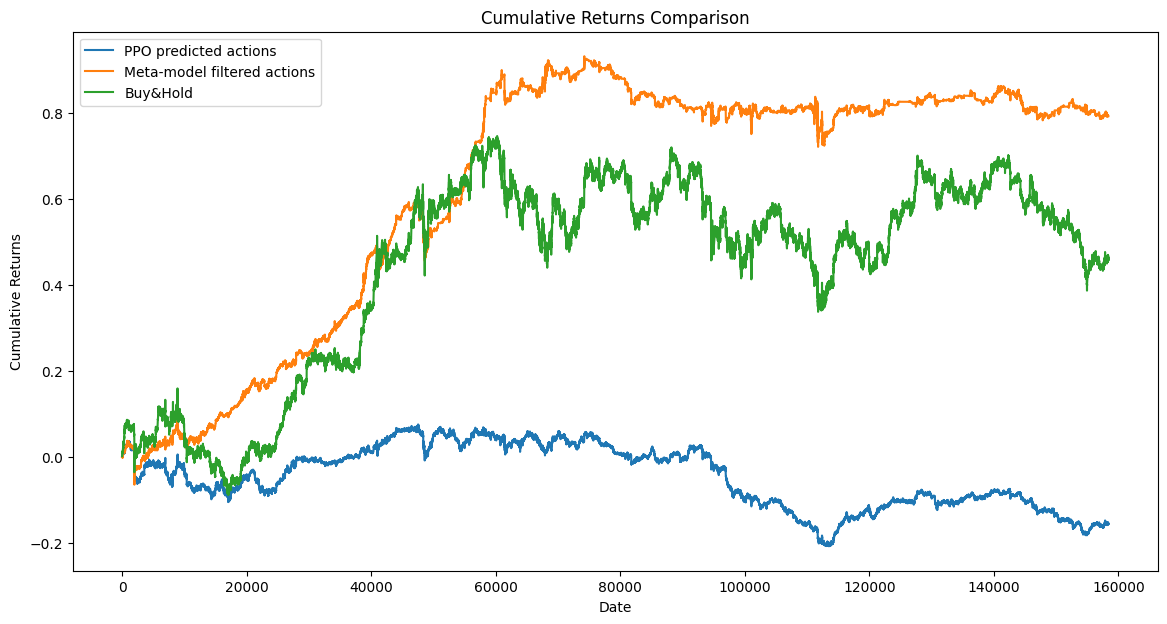

In [29]:
# Crear figura
plt.figure(figsize=(14, 7))

# Calcular el "cumulative returns" de las estrategias y del benchmark
cumulative_returns_strategy1 = (1 + filtered_returns).cumprod() - 1
cumulative_returns_strategy2 = (1 + predicted_returns).cumprod() - 1
cumulative_buy_and_hold = (1 + buy_and_hold).cumprod() - 1

# Graficar
plt.plot(cumulative_returns_strategy2, label='PPO predicted actions')
plt.plot(cumulative_returns_strategy1, label='Meta-model filtered actions')
plt.plot(cumulative_buy_and_hold, label='Buy&Hold')

# Agregar etiquetas y título
plt.title('Cumulative Returns Comparison')
plt.xlabel('Date')
plt.ylabel('Cumulative Returns')
plt.legend()

# Mostrar el gráfico
plt.show()

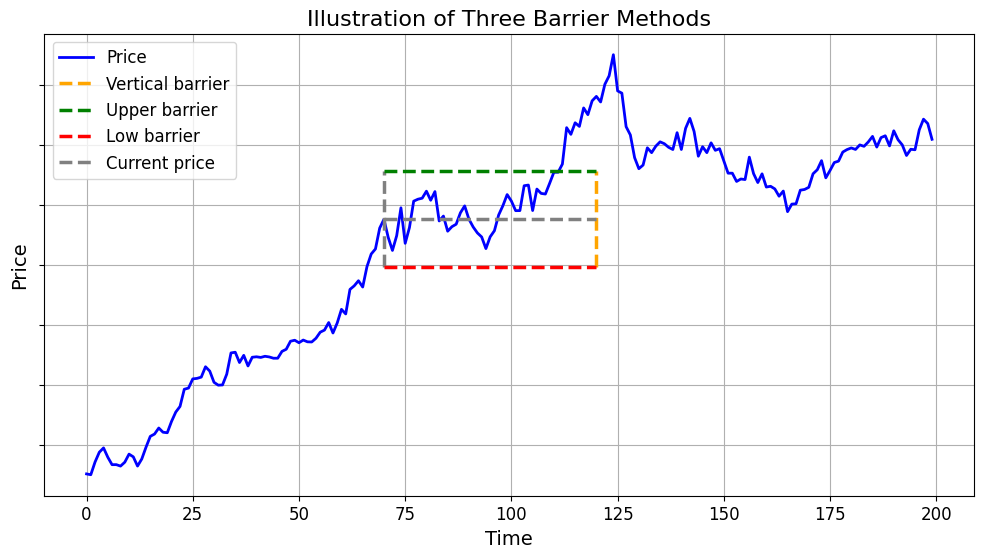

In [30]:
import numpy as np
import matplotlib.pyplot as plt

filename = '3_barried_method'

prices = np.array(BTC_DOLLAR_OO_SAMPLE['close'][300:500])

# Puntos de las barreras
start_point = 70  # Punto inicial en la serie temporal
end_point = 120   # Punto final en la serie temporal

# Barreras de precios
price_barrier_upper = prices[start_point] + 200  # Barrera de precio superior
price_barrier_lower = prices[start_point] - 200  # Barrera de precio inferior

plt.figure(figsize=(12, 6))

# Gráfico de precios
plt.plot(prices, label='Price',lw = 2, color='blue')

# Barreras verticales desde el punto inicial y final
plt.vlines(x=start_point, ymin=price_barrier_lower, ymax=price_barrier_upper, lw = 2.5, color='gray', linestyle='--')
plt.vlines(x=end_point, ymin=price_barrier_lower, ymax=price_barrier_upper, lw = 2.5, color='orange', linestyle='--', label= 'Vertical barrier')

# Barreras de precios horizontales desde el punto inicial hasta el final
plt.hlines(y=price_barrier_upper, xmin=start_point, xmax=end_point, lw = 2.5, color='green', linestyle='--', label='Upper barrier')
plt.hlines(y=price_barrier_lower, xmin=start_point, xmax=end_point, lw = 2.5, color='red', linestyle='--', label='Low barrier')
plt.hlines(y=prices[start_point], xmin=start_point, xmax=end_point, lw = 2.5, color='gray', linestyle='--', label='Current price')

plt.title('Illustration of Three Barrier Methods', fontsize=16)
plt.xlabel('Time', fontsize=14)
plt.ylabel('Price', fontsize=14)
plt.legend(fontsize=12, facecolor='white', framealpha=0.8)
plt.gca().yaxis.set_ticklabels([])

plt.xticks(fontsize=12)
plt.grid(True)
plt.savefig('../tfm/figures/' + filename + '.png')
plt.show()


In [31]:
df = pd.DataFrame({
    'date':final_data['date'],
    'filtered_returns': filtered_returns,
    'predicted_returns': predicted_returns,
    'buy_and_hold': buy_and_hold
})

#df.set_index('date', inplace = True)
df.fillna(0, inplace=True)

# Save the DataFrame to a CSV file
df.to_parquet('meta_model_btc_dollar_results.parquet', index=False)